In [2]:
import pymongo
import spacy
import decouple
import glob
import datetime
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm
from pytrends.request import TrendReq
import tweepy

config = decouple.AutoConfig(' ')
nlp = spacy.load("en_core_web_lg")
pytrends = TrendReq(hl='en-US', tz=360)

In [47]:
gsearch = 'photo'
pytrends.build_payload([gsearch], timeframe='now 4-H')
qrys = pytrends.related_queries()[gsearch]['rising']['query'].values
trend = ' '.join([_q.replace(gsearch, '').replace('  ', ' ').strip() for _q in qrys])
trend

'mon album jean depardieu kolkata fort kolkata kolkata kolkata  result kolkata hot resizer appareil frame shop near me to pdf pose passport size passport size size miles bridges wife size reducer poses for boys to pdf converter online resizer studio near me passport size size in cm passport size dimensions maeva ghennam compressor resizer in kb'

In [37]:
trend = ' '.join(set(trend.split(' '))); trend

'bhagwan na girl eknath joy image naik akhilesh happy rath shinde ramdevpir jay doctor vasantrao jagannath napalm ratha yadav puri hd day yatra jai 2022 family ramapir'

In [4]:
client = pymongo.MongoClient(config('MONGODB_URI'))
client.list_database_names()
db = client.Cluster0
db.list_collection_names()

['test', 'pix']

In [5]:
colpix = db.pix
colpix.count_documents({})

100

In [6]:
# cursor = colpix.find(
#     {'$text': {'$search': 'happy'}}, 
#     {'score': {'$meta': 'textScore'}}
# )

# cursor.sort([('score', {'$meta': 'textScore'})])

In [41]:
pixs = list(colpix.find({ 'feed_id': {'$exists': False}})); len(pixs)

400

In [48]:
sims = []
for _p in tqdm(pixs):
    sims.append((_p['hash'], nlp(trend).similarity(nlp(_p['labels'] + ' ' + _p['colors']))))
    
sims = sorted(sims, key=lambda x: -x[1])
sims[:5]

  0%|          | 0/400 [00:00<?, ?it/s]

[('1823abb878d44aced134b879d3a806f6a4830685b2432a4adff916d43367854b',
  0.6831583654064041),
 ('c49df944d2c5146965a030ce920a2b83296fb352159baac31ec942e12de4de0e',
  0.6791722395913191),
 ('ea34b64ed2e9c7f85ac59aa3e321fca44e7de896b6ceb18972a4d2a3dafcc740',
  0.677916297652685),
 ('61106c96613853fec230016d5c5361084a37423a78566045e6ef6f4b4f676f35',
  0.6752172159403054),
 ('2902d664160c7fd3ffd693fba25bd50fba25f83e579d68093363d791d60d3d67',
  0.6713447202423881)]

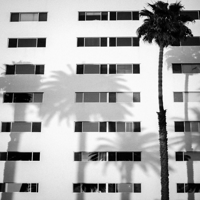

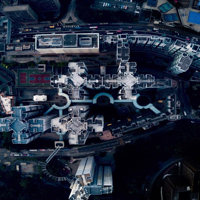

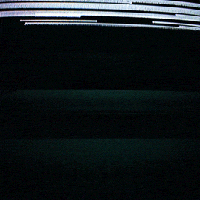

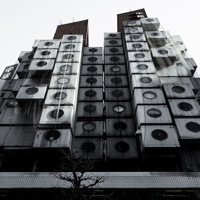

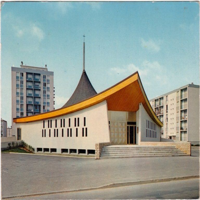

In [49]:
for _fname, _ in sims[:5]:
    _path = glob.glob('imgs/archive/' + _fname + '.*')[0]
    _img = Image.open(_path)
    _img = _img.resize((200, 200))
    display(_img)

In [52]:
_hash = sims[0][0]
pix = colpix.find_one({ 'hash': _hash }); pix

{'_id': ObjectId('62b548d5c7b38aac0d7c8afa'),
 'labels': 'cloud sky billboard rectangle tree pink font signage tints_and_shades magenta pole advertising poster sign cumulus banner',
 'urls': [],
 'colors': 'silver gray',
 'hash': '4a14f1a7ffae60268ab7b0fb07f2b6176bed64e4aca3c0fe280962c1cdb437bf',
 'created_at': datetime.datetime(2022, 6, 24, 5, 17, 9, 85000)}

In [53]:
url = pix['urls'][0]; url

IndexError: list index out of range

In [12]:
pix_upload = glob.glob('imgs/archive/' + _hash + '.*')[0]; pix_upload

'imgs/archive/e0dde30ee30bafe1d99f753ad9b1763e22d5c6a0031f5ae130b787c06bb1e7a2.jpg'

In [39]:
#status = 'crawled from ' + url; status

In [18]:
bearer_token = config('TWITTER_BEARER_TOKEN')
consumer_key = config('TWITTER_CONSUMER_KEY')
consumer_secret = config('TWITTER_CONSUMER_SECRET')
access_token = config('TWITTER_ACCESS_TOKEN')
access_token_secret = config('TWITTER_ACCESS_TOKEN_SECRET')

auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
api = tweepy.API(auth)

In [32]:
media = api.media_upload(filename=pix_upload)
api.create_media_metadata(media.media_id_string, url)
status = api.update_status(status='', media_ids=[media.media_id_string]);

In [35]:
status.id

1540977132155043841

In [37]:
colpix.update_one(
    { 'hash': _hash }, 
    { '$set': { 'feed_id': status.id }}
    # { '$set': { 'posted_at': datetime.datetime.utcnow() }}
)

In [33]:
_timeline = api.user_timeline(); _timeline

[Status(_api=<tweepy.api.API object at 0x7fcf11f6e700>, _json={'created_at': 'Sun Jun 26 08:35:52 +0000 2022', 'id': 1540977132155043841, 'id_str': '1540977132155043841', 'text': 'https://t.co/RPnFTsMu9x', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 1540977125377081345, 'id_str': '1540977125377081345', 'indices': [0, 23], 'media_url': 'http://pbs.twimg.com/media/FWKmh_UagAE9Dt2.jpg', 'media_url_https': 'https://pbs.twimg.com/media/FWKmh_UagAE9Dt2.jpg', 'url': 'https://t.co/RPnFTsMu9x', 'display_url': 'pic.twitter.com/RPnFTsMu9x', 'expanded_url': 'https://twitter.com/piixur/status/1540977132155043841/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1102, 'h': 1200, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 624, 'h': 680, 'resize': 'fit'}, 'large': {'w': 1280, 'h': 1394, 'resize': 'fit'}}}]}, 'extended_entities': {'media': [{'id': 1540977125377081345, 'id_str': '1540977125377

In [34]:
_timeline[0].__dict__

{'_api': <tweepy.api.API at 0x7fcf11f6e700>,
 '_json': {'created_at': 'Sun Jun 26 08:35:52 +0000 2022',
  'id': 1540977132155043841,
  'id_str': '1540977132155043841',
  'text': 'https://t.co/RPnFTsMu9x',
  'truncated': False,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [],
   'media': [{'id': 1540977125377081345,
     'id_str': '1540977125377081345',
     'indices': [0, 23],
     'media_url': 'http://pbs.twimg.com/media/FWKmh_UagAE9Dt2.jpg',
     'media_url_https': 'https://pbs.twimg.com/media/FWKmh_UagAE9Dt2.jpg',
     'url': 'https://t.co/RPnFTsMu9x',
     'display_url': 'pic.twitter.com/RPnFTsMu9x',
     'expanded_url': 'https://twitter.com/piixur/status/1540977132155043841/photo/1',
     'type': 'photo',
     'sizes': {'medium': {'w': 1102, 'h': 1200, 'resize': 'fit'},
      'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
      'small': {'w': 624, 'h': 680, 'resize': 'fit'},
      'large': {'w': 1280, 'h': 1394, 'resize': 'fit'}}}]},
  'ext